# Kunskapskontroll, maskininlärning

### Problemformulering: Train and validate models on the MNIST dataset. Choose the best performing model and evaluate on the test set. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import fetch_openml

import joblib

In [3]:
# Creating a function that will be used later to evaluate models

def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

## Load and investigate the dataset

In [4]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
print('MNIST dictionary keys: ', mnist.keys())   # We can see that the dataset is already divided into data and target labels
print()

# Extract the data and target labels 
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

print('Data and target label sizes: \n{}, {}'.format(X.shape, y.shape))   # We can see that the dataset contains a total of 70,000 samples where each image is 28x28 pixels (giving each image a total of 784 features, 28*28)

c:\Users\tovat\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


MNIST dictionary keys:  dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Data and target label sizes: 
(70000, 784), (70000,)


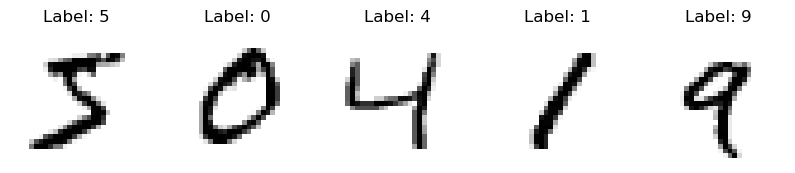

In [4]:
# Reshape images data to 28x28 pixel size
images = X.reshape(-1, 28, 28)

# Display the first 5 images and labels
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.show()  

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 189. 190.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 143. 247. 153.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 136. 247. 242.  86.   0.   0.   0.   0.
   0. 

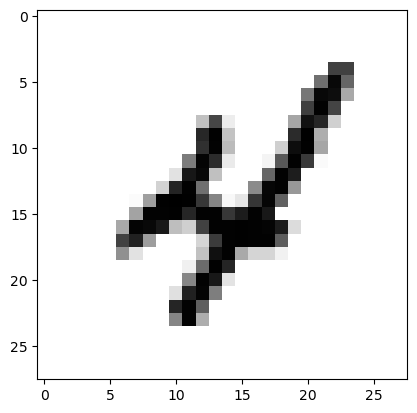

In [5]:
# Check the values of the 10th row and display the corresponding image
print(X[9,:])

plt.imshow(images[9,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

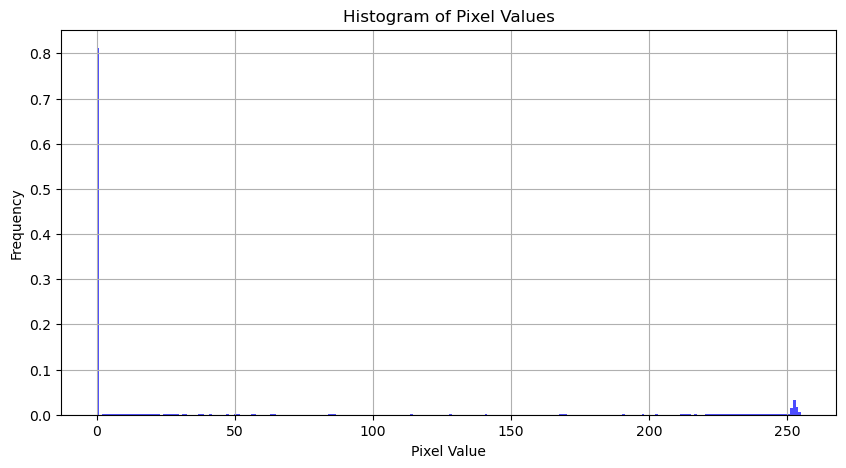

In [30]:
# Check the distribution of pixel values 
plt.figure(figsize=(10, 5))
plt.hist(X.flatten(), bins=256, range=(0, 255), density=True, color='b', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()   # We can see that the images in the dataset are inverted and saved as white digits on a black background (value 0). The histogram also shows there is a large background noise (80% of the pixel values are black)

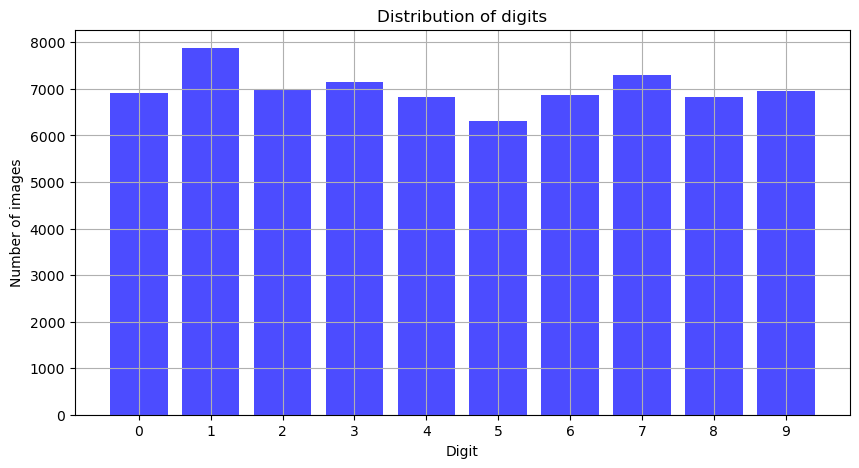

In [29]:
# Check the distribution of digits represented in the dataset
digit_counts = np.bincount(y)

plt.figure(figsize=(10,5))
plt.bar(np.arange(10), digit_counts, color='b', alpha=0.7)
plt.title('Distribution of digits')
plt.xlabel('Digit')
plt.ylabel('Number of images')
plt.xticks(np.arange(10), np.arange(10))
plt.grid(True)
plt.show()   # The dataset seems pretty balanced, with an even distribution of digits represented

### Preparing data for modelling

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

print('Training data and target sizes: \n{}, {}'.format(X_train.shape, y_train.shape))
print()
print('Validation data and target sizes: \n{}, {}'.format(X_val.shape, y_val.shape))
print()
print('Test data and target sizes: \n{}, {}'.format(X_test.shape, y_test.shape))

Training data and target sizes: 
(50000, 784), (50000,)

Validation data and target sizes: 
(10000, 784), (10000,)

Test data and target sizes: 
(10000, 784), (10000,)


In [19]:
# Creating a pipeline for data preprocessing steps
preprocessing = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=.95))
])

# Fitting the pipeline on the training data 
X_train_prep = preprocessing.fit_transform(X_train)
print(f'Total number of components used after PCA : {preprocessing.named_steps["pca"].n_components_}')

# Transforming on test and validation data
X_val_prep = preprocessing.transform(X_val)
X_test_prep = preprocessing.transform(X_test)
print(X_train_prep.shape, X_val_prep.shape, X_test_prep.shape)

# Saving pipeline
joblib.dump(preprocessing, "preprocess.pkl")

Total number of components used after PCA : 327
(50000, 327) (10000, 327) (10000, 327)


['preprocess.pkl']

In [26]:
# Standardizing the data due to SVM (and kNN) being sensitive to nonscaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  
X_test_scaled = scaler.transform(X_test) 

# Initial selection of classifiers
- Instantiating the different classification models
- Fitting them to a smaller batch of the training data and evaluating them on training data as well

In [39]:
# Starting with a simple Linear SVC and training it on a smaller batch of the training data
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled[:5000], y_train[:5000])

y_pred_lin_clf = lin_clf.predict(X_train_scaled)
lin_clf_accuracy = accuracy_score(y_train, y_pred_lin_clf)
print('Accuracy Linear SVC: {:.2f}'.format(lin_clf_accuracy))

c:\Users\tovat\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy Linear SVC: 0.83


c:\Users\tovat\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [40]:
# Trying another linear classifier
log = LogisticRegression(random_state=42)
log.fit(X_train_scaled[:5000], y_train[:5000])

y_pred_log = log.predict(X_train_scaled)
log_accuracy = accuracy_score(y_train, y_pred_log)
print('Accuracy Logistic Regression: {:.2f}'.format(log_accuracy))

Accuracy Logistic Regression: 0.90


c:\Users\tovat\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
# Trying a non-linear SVC
svc = SVC()
svc.fit(X_train_scaled[:5000], y_train[:5000])

y_pred_svc = svc.predict(X_train_scaled)
svc_accuracy = accuracy_score(y_train, y_pred_svc)  # We got a much higher accuracy score using the non-linear SVC!
print('Accuracy SVC: {:.2f}'.format(svc_accuracy))

Accuracy SVC: 0.93


In [42]:
# Trying another non-linear classifier, K-nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train_scaled[:5000], y_train[:5000])

y_pred_knn = knn.predict(X_train_scaled)
knn_accuracy = accuracy_score(y_train, y_pred_knn)  # The SVM is still in the lead when comparing the accuracy score, but the knn is very fast in training.
print('Accuracy K-nearest Neighbors: {:.2f}'.format(knn_accuracy))

Accuracy K-nearest Neighbors: 0.89


In [43]:
# Trying an ensemble learning classifier, Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled[:5000], y_train[:5000])

y_pred_rf = rf.predict(X_train_scaled)
rf_accuracy = accuracy_score(y_train, y_pred_rf)
print('Accuracy Random Forests: {:.2f}'.format(rf_accuracy))

Accuracy Random Forests: 0.94


# Proceeding with the two best performing models
Using a smaller batch of the training set to train the models (speeding up training) and evaluating them on the training data using accuracy score as performance measure, we have two winners; the SVM classifier and Random Forest classifier.

Next step: To select one of these models, we'll do a cross-validation grid search to tune the models for best hyperparameters and evaluate them on validation data using accuracy score and confusion matrix as performance measures.

In [16]:
# Perform hyperparameter tuning for SVC 
param_grid_SVC = {'kernel': ['rbf', 'poly'], 'gamma': [1, 2], 'C': [0.5, 1, 1.5]}
grid_svc = GridSearchCV(svc, param_grid_SVC, cv=3, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_scaled[:5000], y_train[:5000])

joblib.dump(grid_svc, "gridsearch_svc.pkl")

['gridsearch_svc.pkl']

SVC best hyperparameters:  {'C': 0.5, 'gamma': 1, 'kernel': 'poly'}
Accuracy SVC: 0.9411
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       997
           1       0.98      0.97      0.98      1158
           2       0.93      0.92      0.92      1007
           3       0.96      0.91      0.93      1028
           4       0.90      0.96      0.93       966
           5       0.93      0.93      0.93       885
           6       0.97      0.95      0.96       945
           7       0.96      0.94      0.95      1070
           8       0.87      0.94      0.91       988
           9       0.93      0.92      0.92       956

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



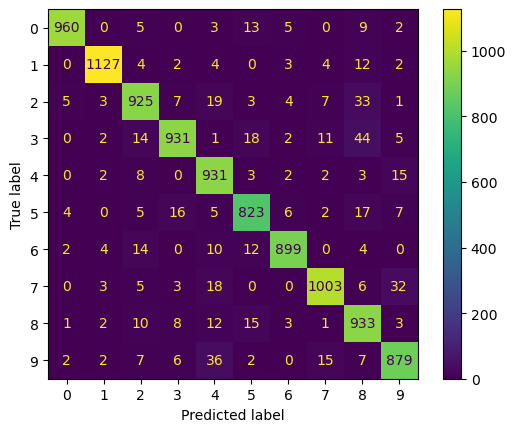

In [51]:
# Extracting the best parameters for SVC
grid_svc = joblib.load("gridsearch_svc.pkl")
print('SVC best hyperparameters: ',grid_svc.best_params_)

# Evaluating on validation data
y_pred_svc = grid_svc.predict(X_val_scaled)
svc_accuracy = accuracy_score(y_val, y_pred_svc)
print('Accuracy SVC: {:.4f}'.format(svc_accuracy))
display_confusion_matrix(y_val, y_pred_svc)
print(classification_report(y_val, y_pred_svc))

In [14]:
# Perform hyperparameter tuning for RF
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_scaled[:5000], y_train[:5000])

joblib.dump(grid_rf, "gridsearch_rf.pkl")

['gridsearch_rf.pkl']

{'max_depth': 20, 'n_estimators': 200}
Accuracy RF: 0.9376
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       997
           1       0.97      0.97      0.97      1158
           2       0.93      0.94      0.93      1007
           3       0.93      0.89      0.91      1028
           4       0.92      0.95      0.94       966
           5       0.91      0.92      0.92       885
           6       0.95      0.97      0.96       945
           7       0.95      0.94      0.95      1070
           8       0.93      0.90      0.92       988
           9       0.91      0.91      0.91       956

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



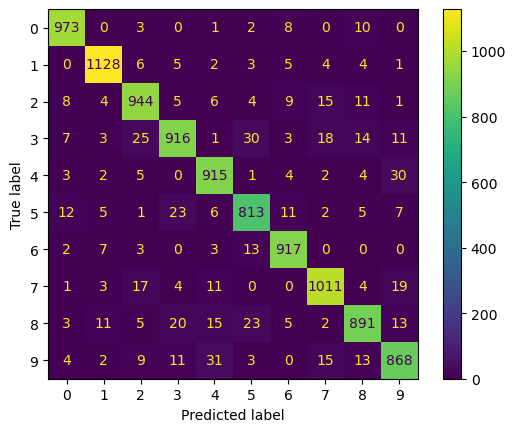

In [50]:
# Extracting the best parameters for RF
grid_rf = joblib.load("gridsearch_rf.pkl")
print(grid_rf.best_params_)

# Evaluating on validation data
y_pred_rf = grid_rf.predict(X_val_scaled)
rf_accuracy = accuracy_score(y_val, y_pred_rf)
print('Accuracy RF: {:.4f}'.format(rf_accuracy))
display_confusion_matrix(y_val, y_pred_rf)
print(classification_report(y_val, y_pred_rf))

In [42]:
# =====================================================================================
# Could run this code and do the gridsearch for both clf combined, but is taking longer
# =====================================================================================

# Instantiating the classifiers
#lin_clf = SVC(random_state=42)
#rf = RandomForestClassifier(random_state=42)

# Define parameter grids for each classifier
#param_grid_SVC = {'kernel': ['rbf', 'poly'], 'gamma': [1, 2], 'C': [0.5, 1, 1.5]}
#param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}

# Create a list of tuples containing each classifier and its corresponding parameter grid
#classifiers = [
    #(svc, param_grid_SVC),
    #(rf, param_grid_rf)
#]

# Perform grid search for each classifier
#for clf, param_grid in classifiers:
    #grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    #grid_search.fit(X_train_scaled[:10000], y_train[:10000])

    #print("Best parameters for {}: {}".format(clf.__class__.__name__, grid_search.best_params_))
    #print("Best score: {:.2f}".format(grid_search.best_score_))

    #joblib.dump(grid_search.best_estimator_, "grid_search.pkl")

Best parameters for SVC: {'C': 0.5, 'gamma': 1, 'kernel': 'poly'}
Best score: 0.88
Best parameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 200}
Best score: 0.92


The SVC model is performing slightly better. Let's see if we should try and tweak the hyperparameters further to get an even better performance score

In [18]:
pd.DataFrame(grid_svc.cv_results_)

# The results from the gridsearchCV shows that the SVC was performing pretty badly with the rbf kernel type
# However, using a poly kernel the mean test score across different values for C (regularization parameter) and gamma (kernel coefficent) stays stable so there is no need to try and fine-tune the hyperparameters further

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,54.538276,0.885749,17.790995,0.875182,0.5,1,rbf,"{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}",0.109778,0.109778,0.109244,0.1096,0.000252,7
1,28.267389,1.420307,8.586941,0.234724,0.5,1,poly,"{'C': 0.5, 'gamma': 1, 'kernel': 'poly'}",0.929214,0.937013,0.930972,0.9324,0.003340,1
2,58.840791,2.145335,17.622550,1.261499,0.5,2,rbf,"{'C': 0.5, 'gamma': 2, 'kernel': 'rbf'}",0.109778,0.109778,0.109244,0.1096,0.000252,7
3,27.513239,1.666636,8.282143,0.232897,0.5,2,poly,"{'C': 0.5, 'gamma': 2, 'kernel': 'poly'}",0.929214,0.937013,0.930972,0.9324,0.003340,1
4,53.222665,3.733837,18.675024,1.806621,1,1,rbf,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.109778,0.109778,0.109244,0.1096,0.000252,7
5,28.357203,1.155451,7.347772,0.476059,1,1,poly,"{'C': 1, 'gamma': 1, 'kernel': 'poly'}",0.929214,0.937013,0.930972,0.9324,0.003340,1
6,56.188806,2.428920,17.291025,0.496999,1,2,rbf,"{'C': 1, 'gamma': 2, 'kernel': 'rbf'}",0.109778,0.109778,0.109244,0.1096,0.000252,7
7,27.754400,0.750443,8.424857,1.105696,1,2,poly,"{'C': 1, 'gamma': 2, 'kernel': 'poly'}",0.929214,0.937013,0.930972,0.9324,0.003340,1
8,57.320200,2.870822,16.389309,0.298687,1.5,1,rbf,"{'C': 1.5, 'gamma': 1, 'kernel': 'rbf'}",0.109778,0.109778,0.109244,0.1096,0.000252,7
9,27.910792,2.217751,6.956752,0.415912,1.5,1,poly,"{'C': 1.5, 'gamma': 1, 'kernel': 'poly'}",0.929214,0.937013,0.930972,0.9324,0.003340,1


# Training and evaluating final model

Training the best performing model, SVC, on the whole training set and evaluating on validation data and later test data

In [20]:
final_model = grid_svc.fit(X_train_scaled, y_train)
joblib.dump(final_model, ("final_model.pkl"))

['final_model.pkl']

Accuracy on validation set: 0.98


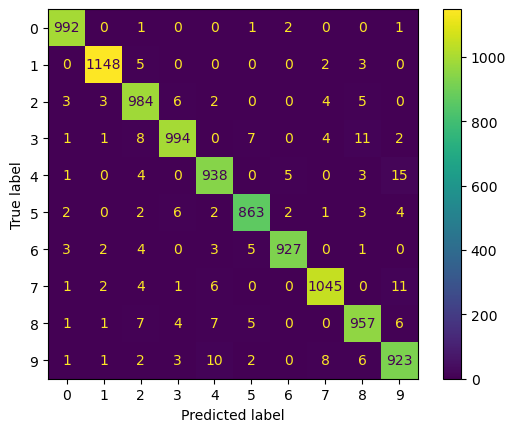

In [21]:
final_model = joblib.load("final_model.pkl")

# New evaluation on the validation set
y_pred = final_model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on validation set: {:.2f}".format(accuracy))   # We got a higher accuracy score when training on the full trainingset
display_confusion_matrix(y_val, y_pred)

In [22]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       997
           1       0.99      0.99      0.99      1158
           2       0.96      0.98      0.97      1007
           3       0.98      0.97      0.97      1028
           4       0.97      0.97      0.97       966
           5       0.98      0.98      0.98       885
           6       0.99      0.98      0.99       945
           7       0.98      0.98      0.98      1070
           8       0.97      0.97      0.97       988
           9       0.96      0.97      0.96       956

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [37]:
# Evaluate the model performance on the test set
final_y_pred = final_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, final_y_pred)
print("Accuracy on test set: {:.2f}".format(test_accuracy))

Accuracy on test set: 0.98
